In [1]:
"""
2018 09 07 Lecture

@author: nhjeong & wilee
"""

#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"


import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Model, model_from_json
from keras.layers import Activation, Conv2D, Input, MaxPool2D, UpSampling2D, Concatenate, BatchNormalization
from keras.optimizers import Adam
import h5py
import scipy.io as sio
from keras import backend as K

Using TensorFlow backend.


In [3]:
N = 44000

X_mat = h5py.File('database/db.mat')
X_input = X_mat['db']
X_train = X_input[0:N, ]
X_val = X_input[N:, ]

Y_mat = h5py.File('database/gt.mat')
Y_input = Y_mat['gt']
Y_train = Y_input[0:N, ]
Y_val = Y_input[N:, ]

X_mat_test = h5py.File('database/test_db.mat')
X_input_test = X_mat_test['test_db']
X_test = X_input_test[0:, ]

Y_mat_test = h5py.File('database/test_gt.mat')
Y_input_test = Y_mat_test['test_gt']
Y_test = Y_input_test[0:, ]


X_mat.close()
Y_mat.close()
X_mat_test.close()
Y_mat_test.close()

In [4]:
# First let's define the two different types of layers that we will be using.

def down(input_layer, filters, pool=True):
    conv = Conv2D(filters, (3, 3), padding='same')(input_layer)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)

    residual = Conv2D(filters, (3, 3), padding='same')(conv)
    residual = BatchNormalization()(residual)
    residual = Activation('relu')(residual)

    if pool:
        max_pool = MaxPool2D()(residual)
        return max_pool, residual
    else:
        return residual

In [5]:
def up(input_layer, residual, filters):
    filters = int(filters)
    upsample = UpSampling2D()(input_layer)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding="same")(upsample)
    concat = Concatenate(axis=3)([residual, upconv])

    conv1 = Conv2D(filters, (3, 3), padding='same')(concat)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)

    conv2 = Conv2D(filters, (3, 3), padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)

    return conv2

In [6]:
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy

    Variables:
        weights: numpy array of shape (C,) where C is the number of classes

    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """

    weights = K.variable(weights)

    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss

    return loss

In [7]:
# Now let's use Tensorflow to write our own dice_coefficient metric

def dice_coef(y_true, y_pred):
    smooth = 1e-5

    y_true = tf.round(tf.reshape(y_true, [-1]))
    y_pred = tf.round(tf.reshape(y_pred, [-1]))

    isct = tf.reduce_sum(y_true * y_pred)

    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)



# Make a custom U-nets implementation.
filters = 32
#input_layer = Input(shape=[256, 256, 1])
input_layer = Input(shape=[64, 64, 1])
layers = [input_layer]
residuals = []

# Down 1, 128
d1, res1 = down(input_layer, filters)
residuals.append(res1)

filters *= 2

# Down 2, 64
d2, res2 = down(d1, filters)
residuals.append(res2)

filters *= 2

# Down 3, 32
d3, res3 = down(d2, filters)
residuals.append(res3)

filters *= 2

# Down 4, 16
d4, res4 = down(d3, filters)
residuals.append(res4)

filters *= 2

# Down 5, 8
d5 = down(d4, filters, pool=False)

# Up 1, 16
up1 = up(d5, residual=residuals[-1], filters=filters / 2)

filters /= 2

# Up 2,  32
up2 = up(up1, residual=residuals[-2], filters=filters / 2)

filters /= 2

# Up 3, 64
up3 = up(up2, residual=residuals[-3], filters=filters / 2)

filters /= 2

# Up 4, 128
up4 = up(up3, residual=residuals[-4], filters=filters / 2)

fc1 = Conv2D(filters=32, kernel_size=(1, 1), activation="relu")(up4)

out = Conv2D(filters=2, kernel_size=(1, 1), activation="softmax")(fc1)

model = Model(input_layer, out)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 64, 64, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [8]:
# Training time!
# probably need to play around a little bit with the learning rate to get it to start learning
model.compile(optimizer=Adam(1e-4), loss=weighted_categorical_crossentropy([1.0, 7.0]), metrics=[dice_coef])
hist = model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_val, Y_val))
loss_train = hist.history['loss']
loss_val = hist.history['val_loss']

Train on 44000 samples, validate on 8037 samples
Epoch 1/10
44000/44000 [==============================] - 121s 3ms/step - loss: 0.0774 - dice_coef: 0.9871 - val_loss: 0.0204 - val_dice_coef: 0.9966
Epoch 2/10
44000/44000 [==============================] - 117s 3ms/step - loss: 0.0143 - dice_coef: 0.9967 - val_loss: 0.0145 - val_dice_coef: 0.9956
Epoch 3/10
44000/44000 [==============================] - 117s 3ms/step - loss: 0.0104 - dice_coef: 0.9974 - val_loss: 0.0122 - val_dice_coef: 0.9969
Epoch 4/10
44000/44000 [==============================] - 117s 3ms/step - loss: 0.0083 - dice_coef: 0.9979 - val_loss: 0.0080 - val_dice_coef: 0.9978
Epoch 5/10
44000/44000 [==============================] - 117s 3ms/step - loss: 0.0074 - dice_coef: 0.9981 - val_loss: 0.0076 - val_dice_coef: 0.9978
Epoch 6/10
44000/44000 [==============================] - 116s 3ms/step - loss: 0.0066 - dice_coef: 0.9983 - val_loss: 0.0072 - val_dice_coef: 0.9982
Epoch 7/10
44000/44000 [===========================

In [10]:
# Saving model
model_json = model.to_json()
with open('unetmodel.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('unetmodel.h5')
print('Saved model to disk')

Saved model to disk


In [9]:
prediction_train = model.predict(X_train[0:1000, ], verbose=0)
prediction_val = model.predict(X_val[0:1000, ], verbose=0)
prediction_test = model.predict(X_test, verbose=0)

score = model.evaluate(X_val, Y_val, verbose=0)
test_score = model.evaluate(X_test, Y_test, verbose=0)

print('validation score : {}'.format(score))
print('test score : {}'.format(test_score))

validation score : [0.0058531648846971455, 0.9986666586471165]
test score : [0.06601039674794815, 0.9967595144678059]


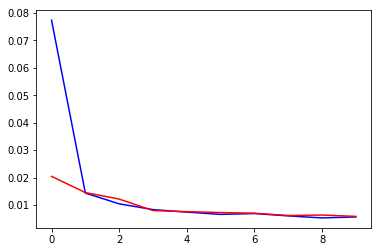

In [12]:
# Loss curve
fig, loss_ax = plt.subplots()
loss_ax.plot(loss_train, 'b', label='train loss')
loss_ax.plot(loss_val, 'r', label='val loss')
plt.show()

Dice coefficient: 96.22 %


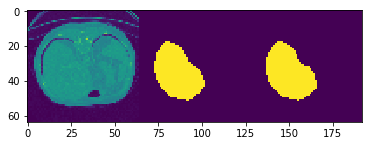

In [15]:
#Loading model
#json_file = open('/home/icsl000004/unetlivervideo_model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
#loaded_model.load_weights('/home/icsl000004/unetlivervideo_model.h5')
#print('Loaded model from disk')

#loaded_model.compile(optimizer=Adam(1e-4), loss=weighted_categorical_crossentropy([1.0, 7.0]), metrics=[dice_coef])
#test_saveload_score = loaded_model.evaluate(X_test, Y_test, verbose=0)
#prediction_train = loaded_model.predict(X_train[0:1000, ], verbose=0)
#prediction_val = loaded_model.predict(X_val[0:1000, ], verbose=0)
#prediction_test = loaded_model.predict(X_test, verbose=0)

# Plotting the result images
index1 = 10
img_train_in = np.squeeze(X_train[index1,])
img_train_ans = np.argmax(Y_train[index1,], axis=2)
img_train_out = np.argmax(prediction_train[index1,], axis=2)

imgplot_train = plt.imshow(np.concatenate((img_train_in, img_train_ans, img_train_out), axis=1))

# Calculating Dice coefficient
N1 = prediction_train.shape[0]
N2 = prediction_test.shape[0]

dice_score = np.zeros(shape = [N2,3])

for i in range(N1):
    img_train_in = np.squeeze(X_train[i,])
    img_train_ans = np.argmax(Y_train[i,], axis=2)
    img_train_out = np.argmax(prediction_train[i,], axis=2)

    isct = np.sum(np.sum(img_train_ans * img_train_out))
    dice_score[i,1] = 2*isct / (np.sum(np.sum(img_train_ans)) + np.sum(np.sum(img_train_out)) + 1e-5)

avg_dice_score_train = np.sum(dice_score[:,1]) / np.count_nonzero(dice_score[:,1]) * 100

print("Dice coefficient: %.2f %%" % avg_dice_score_train)

In [16]:
#def up_fcn1(input_layer, filters):
#    filters = int(filters)
#    upsample = UpSampling2D()(input_layer)
#    upconv = Conv2D(filters, kernel_size=(2, 2), padding="same")(upsample)
#
#    conv1 = Conv2D(filters, (3, 3), padding='same')(upconv)
#    conv1 = BatchNormalization()(conv1)
#    conv1 = Activation('relu')(conv1)
#    return conv1


#def up_fcn2(input_layer, filters):
#    filters = int(filters)
#    upsample = Conv2DTranspose(filters, (3, 3), padding='same',strides=(2,2))(input_layer)
#    return upsample